# Data 607 &mdash; Summer 2023 &mdash; Assignment 1

**Submit a .ipynb file or a Colab link to the your solutions to the appropriate D2L dropbox by 23:59 on Wednesday, March 9. For the Colab link, make sure that the permission is set to "Anyone on the internet with this link can view".**

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

### Exercise 1: It's nice to have lots of data!

We have observed that training accuracy is often a poor proxy for generalization accuracy. The purpose of this exercise is to demonstrate, in an example, that training accuracy and generalization accuracy are comparable if the training set is sufficiently large.

Here is a function to generate some synthetic classification data:

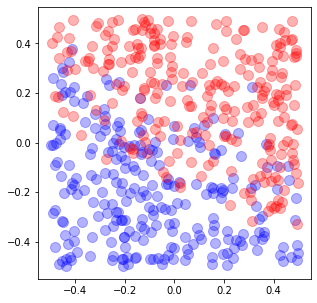

In [ ]:
def make_data(size, s=0.15, theta=np.pi/3):
    u = np.array([np.cos(theta), np.sin(theta)])
    X = np.random.uniform(size=(size, 2)) - 0.5
    e = s*np.random.normal(size=size)
    y = 1*(X @ u + e > 0)
    return X, y

X, y = make_data(500)

plt.figure(figsize=(5,5))
ax = plt.gca()
ax.scatter(*X[y == 0].T, color=(0,0,1,0.3), s=100)
ax.scatter(*X[y == 1].T, color=(1,0,0,0.3), s=100)
ax.set_aspect(1)

Let's generate a big testing set for the purpose of estimating generalization  error:

In [ ]:
X_te, y_te = make_data(100000)

For each $n$ between $100$ and $100000$ in increments of $100$, train a logistic regression model on a training set of size $n$ generated using `make_data`. Estimate the generalizaton accuracy of this model by the accuracy score on the test set constructed above. On the same axes, plot accuracies on the training set and on testing set versus $n$. Observe the behavior of the accuracy curves for large $n$.

Please label your plots!

### Exercise 2: $k$-nearest neighbor regression

Consider a dataset

$$D=\{(x_1, y_1),\ldots,(x_n, y_n)\},$$

where $x_i\in\mathbb{R}^p$ and $y_i\in\mathbb{R}$.

For $x\in\mathbb{R}^p$, let $i_1(x),\ldots,i_n(x)$ be a permutation of the indices $1,\ldots,n$ such that

$$
\|x-x_{i_1(x)}\| \leq \|x-x_{i_2(x)}\| \leq \cdots \leq \|x-x_{i_n(x)}\|.
$$

In particular, $x_{i_1(x)},\ldots,x_{i_k(x)}$ are the $k$-nearest neighbors of $x$ among $x_1,\ldots,x_n$.

The $k$-nearest neighbor regressor $\hat{f}_D$ associated to $D$ is the function that assigns to $x\in \mathbb{R}^p$ the average of the $y$-values associated to the $k$ nearest neighbors of $x$ among $x_1,\ldots,x_n$:

$$
\hat{f}_D(x) = \frac1k \left( y_{i_1(x)} + \cdots + y_{i_k(x)}\right)
$$

In Scikit-Learn, nearest neighbor regressors are instances of the `KNeighborsRegressor` class, which can be imported from `sklearn.neighbors`. Like its classifier counterpart, `KNeighborsRegressor` takes a keyword argument `n_neighbors`, defaulting to `5`.

Here is some code to generate synthetic $1$-dimensional data for a regression problem. The data is distributed around the curve

$$
f(x) = \sqrt{x}\sin^2(2\pi x).
$$

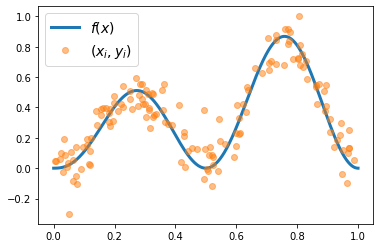

In [ ]:
def f(x):
    return np.sqrt(x)*np.sin(2*np.pi*x)**2

def make_data(size, s=0.1, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    x = np.random.uniform(size=size)
    y = f(x) + s*np.random.normal(size=size)
    return x, y

x, y = make_data(150, random_state=42)
t = np.linspace(0, 1, 1000)
plt.plot(t, f(t), lw=3, label="$f(x)$")
plt.plot(x, y, "o", label="$(x_i, y_i)$", alpha=0.5)
plt.legend(loc="upper left", fontsize=14)
plt.show()

Split the dataset 80%/20% into a training set and a testing set.

Identify an optimal value for `n_neighbors` by randomly splitting training data 80%/20% into a training subset and a validation subset 200 times, imitating the procedure demonstrated in class for nearest neighbor classifiers. The optimal value for `n_neighbors` is the one that minimizes the average mean squared validation error, averaged over all 200 splittings.

Once you've identified an optimal value for `n_neighbors`, refit the model on the original training set and compute the mean squared error on the test set.

Plot the overlay a plot of your $k$-nearest neighbors regressor $\hat{f}_D$ on the curve $f(x)$.

### Exercise 3: Polynomial Regression

Repeat Exercise 2, but with polynomial regression (i.e., a pipeline composed of `PolynomialFeatures` and `LinearRegression`) in place of `KNeighborsRegressor` and the `degree` parameter of `PolynomialFeatures` instead of `n_neighbors`.

### Exercise 4: Diabetes Data

In this exercise, we use the diabetes dataset built into Scikit-Learn. See the [User Guide](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) for information on the dataset.

1. Split the dataset 80%/20% into a training set and a testing set.

2. Fit a linear regression model to the training set. Report the mean squared error on the test set.

3. Using the method of Exercise 2, find an optimal value of `n_neighbors` for a `KNeighborsRegressor` fit to the training data. Once you've identified an optimal value for `n_neighbors`, refit the model on the original training set and compute the mean squared error on the test set.

4. How do the linear regression model and the $k$-nearest neighbors model compare?




### Exercise 5: Breast Cancer Data

In this exercise, we use the breast cancer Wisconsin dataset built into Scikit-Learn. See the [User Guide](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-wisconsin-diagnostic-dataset) for information on the dataset. Note that this dataset is for classification rather than regression.

1. Split the dataset 80%/20% into a training set and a testing set.

2. Fit a logistic regression model to the training set. Report the classification accuracy on the test set.

3. Fit a KNN classificaiton model. Use corss validation to choose the best K, then test on the data.

4. Using a cross-validated grid search (`GridSeachCV`), find an optimal support vector classifier fit to the training set. Support vector classifiers are instances of the `SVC` class, importable from `sklearn.svm`. Search over values of the parameter `C` in `[0.001, 0.01, 0.1, 1, 10, 100, 1000]` and `kernel` in `["linear", "rbf", "poly"]`. Report the best values for `C` and `kernel` and the classification accuracy on the test set associated to the best model.

5. How do the logistic regression classifier, KNN classifier and the support vector classifier compare?

